In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import keras

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [ ]:
!pip install scikit-plot
import scikitplot

In [ ]:
import math
import numpy as np
import pandas as pd

import seaborn as sns
from matplotlib import pyplot

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization, LeakyReLU, Activation
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.utils import np_utils

In [ ]:
!tar xf fer2013.tar.gz

In [ ]:
df = pd.read_csv('fer2013/fer2013.csv')
print(df.shape)
df.head()

(35887, 3)


,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [ ]:
df.emotion.unique()

array([0, 2, 4, 6, 3, 5, 1])

In [ ]:
emotion_label_to_text = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}

In [ ]:
df.emotion.value_counts()

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


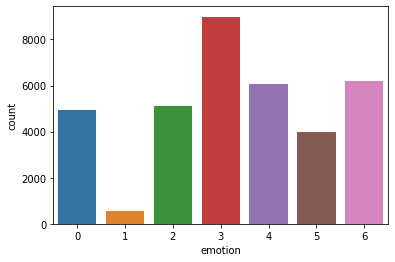

In [ ]:
sns.countplot(df.emotion)
pyplot.show()

`So majority classes belongs to 3:Happy, 4:Sad and 6:Neutral`

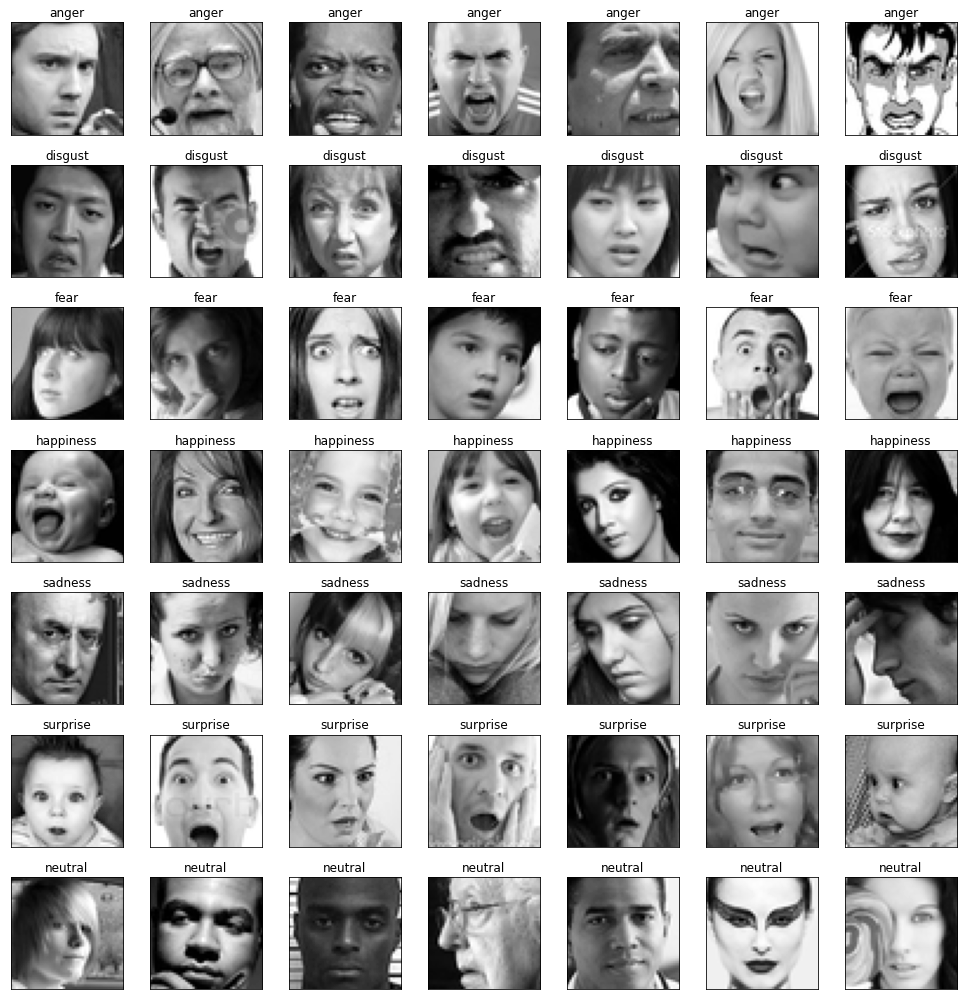

In [ ]:
fig = pyplot.figure(1, (14, 14))

k = 0
for label in sorted(df.emotion.unique()):
    for j in range(7):
        px = df[df.emotion==label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')

        k += 1
        ax = pyplot.subplot(7, 7, k)
        ax.imshow(px, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotion_label_to_text[label])
        pyplot.tight_layout()

In [ ]:
INTERESTED_LABELS = [3, 4, 6]

In [ ]:
# df = df[df.emotion.isin(INTERESTED_LABELS)]
for i, p in enumerate(df['pixels']):
    if len(df['pixels'][i].split(' ')) != 48**2:
        print(i, len(df['pixels'][i].split(' ')))

In [ ]:
df = df.drop(35118)

`Now I will make the data compatible for neural networks.`

In [ ]:
img_array = df.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48, 48, 1).astype('float32'))
img_array = np.stack(img_array, axis=0)

In [ ]:
img_array.shape

(35886, 48, 48, 1)

In [ ]:
le = LabelEncoder()
img_labels = le.fit_transform(df.emotion)
img_labels = np_utils.to_categorical(img_labels)
img_labels.shape

(35886, 7)

In [ ]:
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6}


`Splitting the data into training and validation set.`

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(img_array, img_labels,
                                                    shuffle=True, stratify=img_labels,
                                                    test_size=0.1, random_state=42)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((32297, 48, 48, 1), (3589, 48, 48, 1), (32297, 7), (3589, 7))

In [ ]:
del df
del img_array
del img_labels

In [ ]:
img_width = X_train.shape[1]
img_height = X_train.shape[2]
img_depth = X_train.shape[3]
num_classes = y_train.shape[1]

In [ ]:
# Normalizing results, as neural networks are very sensitive to unnormalized data.
X_train = X_train / 255.
X_valid = X_valid / 255.

In [ ]:
def build_net(optim):
    """
    This is a Deep Convolutional Neural Network (DCNN). For generalization purpose I used dropouts in regular intervals.
    I used `ELU` as the activation because it avoids dying relu problem but also performed well as compared to LeakyRelu
    atleast in this case. `he_normal` kernel initializer is used as it suits ELU. BatchNormalization is also used for better
    results.
    """
    net = Sequential(name='DCNN')

    net.add(
        Conv2D(
            filters=64,
            kernel_size=(5,5),
            input_shape=(img_width, img_height, img_depth),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_1'
        )
    )
    net.add(BatchNormalization(name='batchnorm_1'))
    net.add(
        Conv2D(
            filters=64,
            kernel_size=(5,5),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_2'
        )
    )
    net.add(BatchNormalization(name='batchnorm_2'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_1'))
    net.add(Dropout(0.4, name='dropout_1'))

    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_3'
        )
    )
    net.add(BatchNormalization(name='batchnorm_3'))
    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_4'
        )
    )
    net.add(BatchNormalization(name='batchnorm_4'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_2'))
    net.add(Dropout(0.4, name='dropout_2'))

    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_5'
        )
    )
    net.add(BatchNormalization(name='batchnorm_5'))
    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_6'
        )
    )
    net.add(BatchNormalization(name='batchnorm_6'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_3'))
    net.add(Dropout(0.5, name='dropout_3'))

    net.add(Flatten(name='flatten'))
        
    net.add(
        Dense(
            128,
            activation='elu',
            kernel_initializer='he_normal',
            name='dense_1'
        )
    )
    net.add(BatchNormalization(name='batchnorm_7'))
    
    net.add(Dropout(0.6, name='dropout_4'))
    
    net.add(
        Dense(
            num_classes,
            activation='softmax',
            name='out_layer'
        )
    )
    
    net.compile(
        loss='categorical_crossentropy',
        optimizer=optim,
        metrics=['accuracy']
    )
    
    net.summary()
    
    return net

In [ ]:
"""
I used two callbacks one is `early stopping` for avoiding overfitting training data
and other `ReduceLROnPlateau` for learning rate.
"""

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
    early_stopping,
    lr_scheduler,
]

In [ ]:
# As the data in hand is less as compared to the task so ImageDataGenerator is good to go.
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
)
train_datagen.fit(X_train)

In [ ]:
batch_size = 32 #batch size of 32 performs the best.
epochs = 300
optims = [
    optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name='Nadam'),
    optimizers.Adam(0.001),
]

# I tried both `Nadam` and `Adam`, the difference in results is not different but I finally went with Nadam as it is more popular.
model = build_net(optims[1]) 
history = model.fit_generator(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_valid, y_valid),
    steps_per_epoch=len(X_train) / batch_size,
    epochs=epochs,
    callbacks=callbacks,
    use_multiprocessing=True
)

Model: "DCNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 64)        1664      
_________________________________________________________________
batchnorm_1 (BatchNormalizat (None, 48, 48, 64)        256       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 48, 48, 128)       73856     
_________________________________________________________________
batchnorm_4 (BatchNormalizat (None, 48, 48, 128)       512       
_________________________________________________________________
maxpool2d_2 (MaxPooling2D)   (None, 24, 24, 128)       0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 24, 24, 128)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 24, 24, 256)       295168 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


1009/1009 [==============================] - 70s 62ms/step - loss: 2.3063 - accuracy: 0.2180 - val_loss: 1.6207 - val_accuracy: 0.3672
Epoch 2/300
1009/1009 [==============================] - 62s 61ms/step - loss: 1.6979 - accuracy: 0.3254 - val_loss: 1.5523 - val_accuracy: 0.4168
Epoch 3/300
1009/1009 [==============================] - 62s 61ms/step - loss: 1.5727 - accuracy: 0.3850 - val_loss: 1.4277 - val_accuracy: 0.4497
Epoch 4/300
1009/1009 [==============================] - 62s 61ms/step - loss: 1.4732 - accuracy: 0.4320 - val_loss: 1.2784 - val_accuracy: 0.5216
Epoch 5/300
1009/1009 [==============================] - 62s 62ms/step - loss: 1.4152 - accuracy: 0.4592 - val_loss: 1.2568 - val_accuracy: 0.5213
Epoch 6/300
1009/1009 [==============================] - 62s 61ms/step - loss: 1.3604 - accuracy: 0.4823 - val_loss: 1.2052 - val_accuracy: 0.5403
Epoch 7/300
1009/1009 [==============================] - 62s 61ms/step - loss: 1.3162 - accuracy: 0.4986 - val_loss: 1.1736 - val_

1009/1009 [============================>.] - ETA: 0s - loss: 0.8113 - accuracy: 0.7041WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.
1009/1009 [==============================] - 51s 51ms/step - loss: 0.8113 - accuracy: 0.7041 - val_loss: 0.8847 - val_accuracy: 0.7002
Restoring model weights from the end of the best epoch.
Epoch 00086: early stopping

In [ ]:
model_yaml = model.to_yaml()
with open("model.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)
    
model.save("model.h5")

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

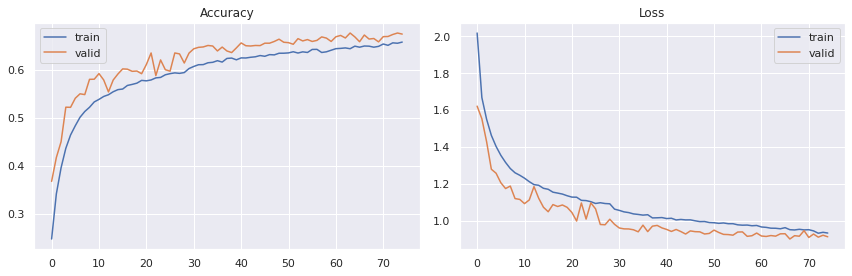

In [ ]:
sns.set()
fig = pyplot.figure(0, (12, 4))

ax = pyplot.subplot(1, 2, 1)
sns.lineplot(history.epoch, history.history['accuracy'], label='train')
sns.lineplot(history.epoch, history.history['val_accuracy'], label='valid')
pyplot.title('Accuracy')
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.lineplot(history.epoch, history.history['loss'], label='train')
sns.lineplot(history.epoch, history.history['val_loss'], label='valid')
pyplot.title('Loss')
pyplot.tight_layout()

pyplot.savefig('epoch_history_dcnn.png')
pyplot.show()

    The epochs history shows that accuracy gradually increases and achieved +83% accuracy on both training and validation set, but at the end the model starts overfitting training data.

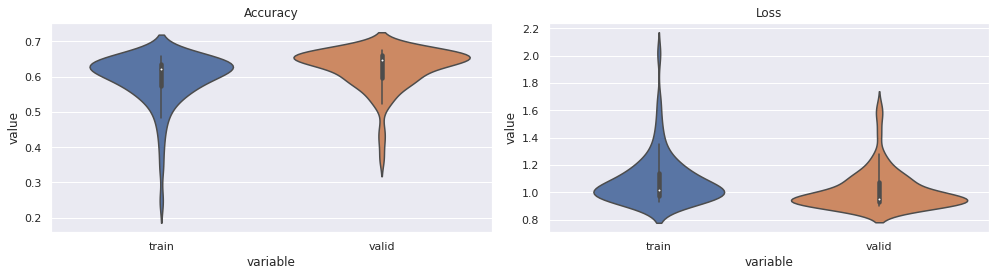

In [ ]:
df_accu = pd.DataFrame({'train': history.history['accuracy'], 'valid': history.history['val_accuracy']})
df_loss = pd.DataFrame({'train': history.history['loss'], 'valid': history.history['val_loss']})

fig = pyplot.figure(0, (14, 4))
ax = pyplot.subplot(1, 2, 1)
sns.violinplot(x="variable", y="value", data=pd.melt(df_accu), showfliers=False)
pyplot.title('Accuracy')
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.violinplot(x="variable", y="value", data=pd.melt(df_loss), showfliers=False)
pyplot.title('Loss')
pyplot.tight_layout()

pyplot.savefig('performance_dist.png')
pyplot.show()

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


total wrong validation predictions: 1163


              precision    recall  f1-score   support

           0       0.62      0.62      0.62       495
           1       0.75      0.38      0.51        55
           2       0.57      0.36      0.44       512
           3       0.86      0.87      0.87       899
           4       0.57      0.58      0.58       608
           5       0.75      0.78      0.77       400
           6       0.58      0.75      0.65       620

    accuracy                           0.68      3589
   macro avg       0.67      0.62      0.63      3589
weighted avg       0.68      0.68      0.67      3589



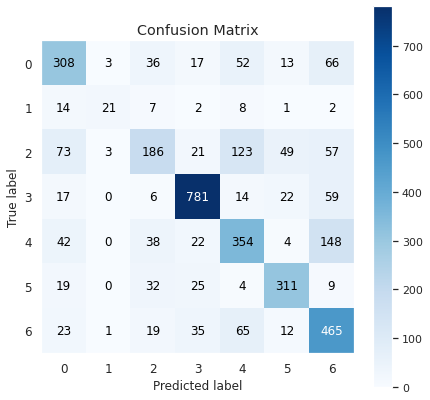

In [ ]:
yhat_valid = model.predict_classes(X_valid)
scikitplot.metrics.plot_confusion_matrix(np.argmax(y_valid, axis=1), yhat_valid, figsize=(7,7))
pyplot.savefig("confusion_matrix_dcnn.png")

print(f'total wrong validation predictions: {np.sum(np.argmax(y_valid, axis=1) != yhat_valid)}\n\n')
print(classification_report(np.argmax(y_valid, axis=1), yhat_valid))

The confusion matrix clearly shows that our model is doing good job on the class `happy` but it's performance is low on other two classes. One of the reason for this could be the fact that these two classes have less data. But when I looked at the images I found some images from these two classes are even hard for a human to tell whether the person is sad or neutral. Facial expression depends on individual as well. Some person's neutral face looks like sad.

In [ ]:
mapper = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


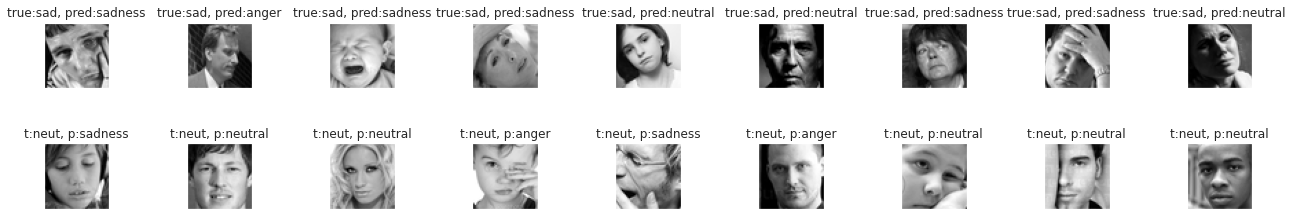

In [ ]:
np.random.seed(2)
random_sad_imgs = np.random.choice(np.where(y_valid[:, 4]==1)[0], size=9)
random_neutral_imgs = np.random.choice(np.where(y_valid[:, 6]==1)[0], size=9)

fig = pyplot.figure(1, (18, 4))

for i, (sadidx, neuidx) in enumerate(zip(random_sad_imgs, random_neutral_imgs)):
        ax = pyplot.subplot(2, 9, i+1)
        sample_img = X_valid[sadidx,:,:,0]
        ax.imshow(sample_img, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"true:sad, pred:{mapper[model.predict_classes(sample_img.reshape(1,48,48,1))[0]]}")

        ax = pyplot.subplot(2, 9, i+10)
        sample_img = X_valid[neuidx,:,:,0]
        ax.imshow(sample_img, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"t:neut, p:{mapper[model.predict_classes(sample_img.reshape(1,48,48,1))[0]]}")

        pyplot.tight_layout()

See in the first row 7th image looks more like neutral rather than sad and our model even predicted it neutral. Whereas the last image in second row is very much sad.

In [ ]:
save_path = os.path.join("emo_model", "1/")
tf.saved_model.save(model, save_path)

INFO:tensorflow:Assets written to: emo_model/1/assets


In [ ]:
!tar -cvf emo_model.tar emo_model/

emo_model/
emo_model/1/
emo_model/1/assets/
emo_model/1/variables/
emo_model/1/variables/variables.data-00000-of-00001
emo_model/1/variables/variables.index
emo_model/1/saved_model.pb


In [ ]:
!pip install tf-nightly

     |████████████████████████████████| 408.5MB 43kB/s 
     |████████████████████████████████| 5.9MB 22.4MB/s 
     |████████████████████████████████| 4.0MB 37.5MB/s 
     |████████████████████████████████| 471kB 36.6MB/s 
     |████████████████████████████████| 4.0MB 35.3MB/s 
     |████████████████████████████████| 3.8MB 31.1MB/s 
ERROR: tensorflow 2.4.1 has requirement gast==0.3.3, but you'll have gast 0.4.0 which is incompatible.
ERROR: tensorflow 2.4.1 has requirement grpcio~=1.32.0, but you'll have grpcio 1.34.1 which is incompatible.
ERROR: tensorflow 2.4.1 has requirement h5py~=2.10.0, but you'll have h5py 3.1.0 which is incompatible.
  Found existing installation: grpcio 1.32.0
    Uninstalling grpcio-1.32.0:
      Successfully uninstalled grpcio-1.32.0
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation: h5py 2.10.0
    Uninstalling h5py-2.10.0:
      Successfully uninstalled h5py-2.10

In [ ]:
# from  tensorflow.lite.python import convert_saved_model

model = keras.models.load_model('model.h5')
keras_file = 'saved_model.h5'
#keras.models.save_model(model, keras_file)

#model = tf.saved_model.load(save_path)
#convert to TFLite

# converter = tf.lite.TFLiteConverter.from_keras_model(model)
# converter.optimizations = [tf.lite.Optimize.DEFAULT]
# tflite_model = converter.convert()


###Trying to get full int quantization
# import tensorflow.python.ops.numpy_ops.np_config

# np_config.enable_numpy_behavior()

# def representative_dataset():
#   for data in tf.data.Dataset.from_tensor_slices((df.pixels)).batch(1).take(100):
#     yield [data.astype]#(tf.float32)]

# converter = tf.lite.TFLiteConverter.from_keras_model(model)
# converter.optimizations = [tf.lite.Optimize.DEFAULT]
# converter.representative_dataset = representative_dataset
# converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# converter.inference_input_type = tf.int8  # or tf.uint8
# converter.inference_output_type = tf.int8  # or tf.uint8
# tflite_quant_model = converter.convert()

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.experimental_new_converter = True
tflite_model = converter.convert()

# converter = tf.lite.TFLiteConverter.from_saved_model(model)
# converter = tf.lite.TFLiteConverter.from_keras_model(model)
# converter.optimizations = [tf.lite.Optimize.DEFAULT]
# tflite_model = convert_saved_model.tflite_from_saved_model()
open('emotions.tflite', 'wb').write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpxgwpm1w0/assets


INFO:tensorflow:Assets written to: /tmp/tmpxgwpm1w0/assets


AttributeError: ignored

In [ ]:
# from tensorflow.contrib import lite

# keras_file = 'saved_model.h5'
# keras.models.save_model(model, keras_file)

# model = tf.saved_model.load(save_path)
# #convert to TFLite
# converter = tf.lite.TFLiteConverter.from_keras_model(model)
# converter.optimizations = [tf.lite.Optimize.DEFAULT]
# tflite_model = converter.convert()
# open('emotions_4layer.tflite', 'wb').write(tflite_model)

Load tflite model and run it

In [ ]:
!pip3 install --extra-index-url https://google-coral.github.io/py-repo/ tflite_runtime

In [ ]:
import numpy as np
import tflite_runtime.interpreter as tflite
from PIL import Image

image = Image.open('small head.jpg').convert('L').resize((48,48))
image = np.asarray(image, dtype=np.float32)/255
image = tf.expand_dims(image, 2)
# Load the TFLite model and allocate tensors.
interpreter = tflite.Interpreter(model_path="emotions.tflite")
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test the model on random input data.
input_shape = input_details[0]['shape']
input_data = np.array(np.random.random_sample(input_shape), dtype=np.float32)
interpreter.set_tensor(input_details[0]['index'], [image])

interpreter.invoke()

# The function `get_tensor()` returns a copy of the tensor data.
# Use `tensor()` in order to get a pointer to the tensor.
output_data = interpreter.get_tensor(output_details[0]['index'])
print(output_data, mapper[np.where(output_data[0] == np.max(output_data[0]))[0][0]])

In [ ]:

image = tf.expand_dims(image, 0)

NameError: ignored

In [ ]:
from google.colab.patches import cv2_imshow
import random
np.shape(X_valid[2,:,:,0])

input_data = np.array(np.random.random_sample(input_shape), dtype=np.float32)

for i in range(10):
    a = random.randint(0, 200)
    # print(a)
    interpreter.set_tensor(input_details[0]['index'], [X_valid[a]])

    interpreter.invoke()

    cv2_imshow(X_valid[a,:,:,0]*255)

    # The function `get_tensor()` returns a copy of the tensor data.
    # Use `tensor()` in order to get a pointer to the tensor.
    output_data = interpreter.get_tensor(output_details[0]['index'])

    print("Guess: ", mapper[np.where(output_data[0] == np.max(output_data[0]))[0][0]], "(%.02f%%)" % np.max(output_data[0]*100))
    print("Label: ", mapper[np.where(y_valid[a] == 1)[0][0]], '\n')

In [ ]:
image = Image.open('idris.jpg').convert('L').crop((1400, 210, 2500, 1700)).resize((48,48))
image = np.asarray(image, dtype=np.float32)/255
image = np.expand_dims(image, axis=2)
np.shape(image)

In [1]:
from PIL import Image
import tensorflow.compat.v1 as tf
image = Image.open('small head.jpg').convert('L')
print(np.shape(image))
image = np.asarray(image, dtype=np.float32)/255
image = tf.expand_dims(image, 0)
image_shape = [48, 48]
image = tf.image.resize_images(
      image,
      image_shape,
      method=tf.image.ResizeMethod.NEAREST_NEIGHBOR,
      align_corners=True)
print(np.shape(image))

FileNotFoundError: ignored

In [ ]:
interpreter.set_tensor(input_details[0]['index'], [image])

interpreter.invoke()

cv2_imshow(image*255)

# The function `get_tensor()` returns a copy of the tensor data.
# Use `tensor()` in order to get a pointer to the tensor.
output_data = interpreter.get_tensor(output_details[0]['index'])

print("Guess: ", mapper[np.where(output_data[0] == np.max(output_data[0]))[0][0]], "(%.02f%%)" % np.max(output_data[0]*100))
# print("Label: ", mapper[np.where(y_valid[a] == 1)[0][0]], '\n')

In [ ]:
a, b, c, d = np.random.randint(-5, 5, size=4)*40
a, b, c, d

In [ ]:

for i in range(10):
    a, b, c, d = np.random.randint(-5, 5, size=4)*100
    image = Image.open('idris.jpg').convert('L').crop((1400+a, 210+b, 2500+a+c, 1700+b+d)).resize((48,48))
    image = np.asarray(image, dtype=np.float32)/255
    image = np.expand_dims(image, axis=2)
    interpreter.set_tensor(input_details[0]['index'], [image])

    interpreter.invoke()

    cv2_imshow(image*255)

    # The function `get_tensor()` returns a copy of the tensor data.
    # Use `tensor()` in order to get a pointer to the tensor.
    output_data = interpreter.get_tensor(output_details[0]['index'])

    print("Guess: ", mapper[np.where(output_data[0] == np.max(output_data[0]))[0][0]], "(%.02f%%)" % np.max(output_data[0]*100))

In [ ]:
image = np.asarray(image, dtype=np.float32)
image = np.expand_dims(image, axis=2)
np.shape(image)

In [ ]:
x = X_valid[1]
np.shape(x), x

In [ ]:
yhat_valid = interpreter.predict_classes(X_valid)
scikitplot.metrics.plot_confusion_matrix(np.argmax(y_valid, axis=1), yhat_valid, figsize=(7,7))
pyplot.savefig("confusion_matrix_dcnn.png")

print(f'total wrong validation predictions: {np.sum(np.argmax(y_valid, axis=1) != yhat_valid)}\n\n')
print(classification_report(np.argmax(y_valid, axis=1), yhat_valid))

In [ ]:

new_model = keras.models.load_model('/content/emo_model/1/')
new_model.summary()

In [ ]:
yhat_valid = new_model.predict_classes(X_valid)
scikitplot.metrics.plot_confusion_matrix(np.argmax(y_valid, axis=1), yhat_valid, figsize=(7,7))
pyplot.savefig("confusion_matrix_dcnn.png")

print(f'total wrong validation predictions: {np.sum(np.argmax(y_valid, axis=1) != yhat_valid)}\n\n')
print(classification_report(np.argmax(y_valid, axis=1), yhat_valid))

In [ ]:
import time
for i in range(1000):
    print(i)
    time.sleep(100)